In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

#import keras
from keras.models import Model,load_model
from keras.layers import Input, Embedding, Flatten, Dot, Dense, Dropout

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

Using TensorFlow backend.


In [2]:
data = pd.read_csv('ratings.csv')

In [3]:
data.head()

,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5
3,1,1169,4
4,1,1185,4


In [4]:
n_users = data.user_id.nunique()
n_books = data.book_id.nunique()
n_users,n_books

(53424, 10000)

In [5]:
train,test = train_test_split(data, test_size=0.2,random_state=42)

# Build a collaborative filtering model

Framing the problem for the simplist model:
Create embeddings for users and embeddings for products such that the dot product
of the two results in the users rating of the product

There are numerous other options:
- Follow the dot() with a dropout then a dense layer then an output layer, to basically create an embedding for the dot product. When tested on this dataset, this significantly improved performance.
- Use concatenate(,axis=1) instead of dot() to preserve the representation of both embeddings, follow this with some dense layers.


In [6]:
book_input = Input(shape=(1,),name='book_input')
book_embed = Embedding(n_books+1,5,name='book_embed')(book_input)
book_vec = Flatten(name='book_vec')(book_embed)

user_input = Input(shape=(1,),name='user_input')
user_embed = Embedding(n_users+1, 5,name='user_embed')(user_input)
user_vec = Flatten(name='user_vec')(user_embed)

prod = Dot(name='dot_product',axes=1)([book_vec,user_vec])

model = Model([book_input,user_input],prod)

In [7]:
model.compile(optimizer='adam',loss='mse',metrics=['mae'])
history = model.fit([train.book_id,train.user_id], train.rating, epochs=5,validation_split=0.2)

Train on 628323 samples, validate on 157081 samples
Epoch 1/5
 16832/628323 [..............................] - ETA: 1:24 - loss: 15.8260 - mean_absolute_error: 3.8545

KeyboardInterrupt: 

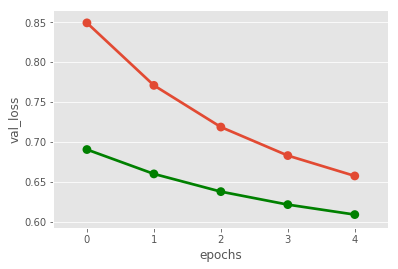

In [38]:
df = pd.DataFrame({'epochs':history.epoch,'train_loss':history.history['loss'],'val_loss':history.history['mean_absolute_error']})
g = sns.pointplot(data=df, x='epochs',y='train_loss',fit_reg=False)
g = sns.pointplot(data=df, x='epochs',y='val_loss',fit_reg=False,color='green')

Note: The above was actually after 10 epochs

### Try using some dense layers after the dot product

In [8]:
book_input = Input(shape=(1,),name='book_input')
book_embed = Embedding(n_books+1,5,name='book_embed')(book_input)
book_vec = Flatten(name='book_vec')(book_embed)

user_input = Input(shape=(1,),name='user_input')
user_embed = Embedding(n_users+1, 5,name='user_embed')(user_input)
user_vec = Flatten(name='user_vec')(user_embed)

prod = Dot(name='dot_product',axes=1)([book_vec,user_vec])
drop = Dropout(0.5)(prod)
dense = Dense(4,activation='relu')(drop)
pred = Dense(1)(dense)

model = Model([book_input,user_input],pred)

model.compile(optimizer='adam',loss='mse',metrics=['mae'])
history = model.fit([train.book_id,train.user_id], train.rating, epochs=5,validation_split=0.2)

model.save('dense-dot-recsys.h5')

Train on 628323 samples, validate on 157081 samples
Epoch 1/5
628323/628323 [==============================] - 82s 131us/step - loss: 1.2223 - mean_absolute_error: 0.8524 - val_loss: 0.9636 - val_mean_absolute_error: 0.7826
Epoch 2/5
628323/628323 [==============================] - 82s 130us/step - loss: 0.9353 - mean_absolute_error: 0.7706 - val_loss: 0.9395 - val_mean_absolute_error: 0.7797
Epoch 3/5
628323/628323 [==============================] - 81s 129us/step - loss: 0.8867 - mean_absolute_error: 0.7444 - val_loss: 0.9154 - val_mean_absolute_error: 0.7521
Epoch 4/5
628323/628323 [==============================] - 81s 129us/step - loss: 0.8514 - mean_absolute_error: 0.7229 - val_loss: 0.8938 - val_mean_absolute_error: 0.7519
Epoch 5/5
628323/628323 [==============================] - 81s 128us/step - loss: 0.8256 - mean_absolute_error: 0.7066 - val_loss: 0.8813 - val_mean_absolute_error: 0.7381


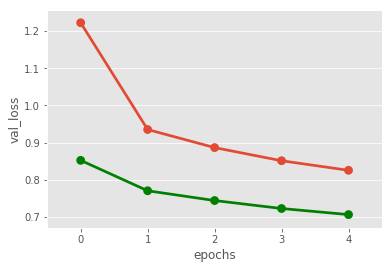

In [11]:
df = pd.DataFrame({'epochs':history.epoch,'train_loss':history.history['loss'],'val_loss':history.history['mean_absolute_error']})
g = sns.pointplot(data=df, x='epochs',y='train_loss',fit_reg=False)
g = sns.pointplot(data=df, x='epochs',y='val_loss',fit_reg=False,color='green')

In [12]:
print(model.metrics_names)

['loss', 'mean_absolute_error']


In [13]:
model.evaluate([test.book_id, test.user_id], test.rating)

196352/196352 [==============================] - 7s 36us/step


[0.8882977161532197, 0.7404442687155837]

#### Get predictions 

In [14]:
predictions = model.predict([test.book_id.head(10), test.user_id.head(10)])
[print(predictions[i],test.rating.iloc[i]) for i in range(0,10)]

[4.33416] 5
[4.059675] 4
[3.8435693] 3
[3.8210711] 5
[3.8847165] 3
[4.272991] 3
[3.6269357] 3
[3.7137744] 4
[3.9432304] 3
[4.128763] 5


[None, None, None, None, None, None, None, None, None, None]

### Visualize the Book Embeddings

In [15]:
book_emb = model.get_layer('book_embed')
book_emb_weights = book_emb.get_weights()[0] #get_weights() returns (weights, bias) but embeddings don't have a bias

In [16]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_result = pca.fit_transform(book_emb_weights)

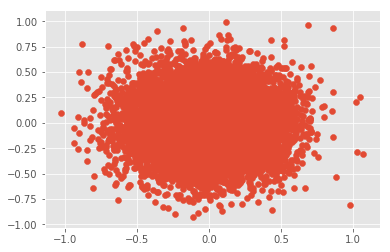

In [17]:

plt.scatter(x=pca_result[:,0], y=pca_result[:,1])

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


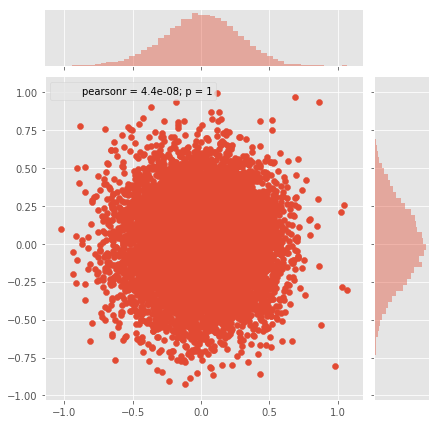

In [18]:
sns.jointplot(x=pca_result[:,0], y=pca_result[:,1])

In [19]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tnse_results = tsne.fit_transform(book_emb_weights)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10001 samples in 0.004s...
[t-SNE] Computed neighbors for 10001 samples in 0.680s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10001
[t-SNE] Computed conditional probabilities for sample 2000 / 10001
[t-SNE] Computed conditional probabilities for sample 3000 / 10001
[t-SNE] Computed conditional probabilities for sample 4000 / 10001
[t-SNE] Computed conditional probabilities for sample 5000 / 10001
[t-SNE] Computed conditional probabilities for sample 6000 / 10001
[t-SNE] Computed conditional probabilities for sample 7000 / 10001
[t-SNE] Computed conditional probabilities for sample 8000 / 10001
[t-SNE] Computed conditional probabilities for sample 9000 / 10001
[t-SNE] Computed conditional probabilities for sample 10000 / 10001
[t-SNE] Computed conditional probabilities for sample 10001 / 10001
[t-SNE] Mean sigma: 0.110200
[t-SNE] KL divergence after 250 iterations with early exaggeration: 90.902519
[t-SNE] Er

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


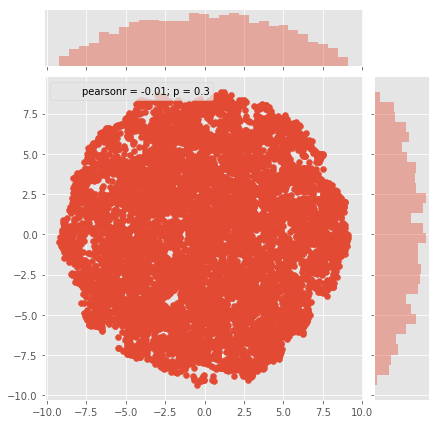

In [20]:
sns.jointplot(x=tnse_results[:,0], y=tnse_results[:,1])

# Make Recommendations

Feed in 1 user and ALL books: Then select the books that have the highest predicted rating for that specific user.

To do this, we need to pair that user with each book. So, we need a list of all of the unique books. Then we we're going to create a list for the user, where we replicate the user's ID so that it is the same length as the unique book list. So if we had 3 total books, and we wanted to generate recommendations for user_1, our inputs would look like:

    book_list=[1,2,3]
    user_1= [1,1,1]
 
This will give us a ratings_list of length 3, 1 rating for each book for that user.

Note: It's probably a really good idea to have product ids that go 0-N, and to sort the product_list numerically so that interpretation doesn't get weird when you argsort. 

Obviously this is naive, and ignores the fact that the user may have read some of these books, but we could check for that as a next step

In [22]:
# get a list of all the books
book_list = np.array(list(set(data.book_id)))

In [31]:
# replicate the user's ID once for each book in the book_list
user_id = 1
user = np.array([user_id for i in range(len(book_list))])
user[:3]

array([1, 1, 1])

In [45]:
# get the ratings
predicted_ratings = model.predict([user,book_list]) # returns a list of lists, where there is 1 item in each list, the predicted rating
predicted_ratings = np.array([i[0] for i in predicted_ratings])
# argsort() returns the indices of an array, sorted lowest to highest
# we want the indices of the top-n not the bottom-n, argsort doesn't have a nice way to do this
# so we just flop the sign on the array. Before 1 would be low and 5 high, but now -5 is low and -1 is high
recommended_book_ids = (-predicted_ratings).argsort()


In [57]:
#get the top_n book_ids
top_5 = recommended_book_ids[:5]
# get the predicted rating for each recommendation
#predicted_ratings[top_5]
# print book_id, rating
print(list(zip(top_5,predicted_ratings[top_5])))

[(7866, 4.760627), (3640, 4.704914), (8137, 4.5900717), (8530, 4.5637226), (3454, 4.5137568)]


To figure out which books were recommended to the user, we can examine the product descriptions associated with the book_ids

In [58]:
books = pd.read_csv('books.csv')
books.head()

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


In [60]:
top_5_descriptions = books[books['id'].isin(top_5)]
top_5_descriptions

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
3453,3454,84140,6567284,81269,50,312984820,9.780313e+12,Sherrilyn Kenyon,2002.0,"Night Embrace (Dark-Hunter, #2)",...,29663,47936,1481,271,1231,7525,16207,22702,https://images.gr-assets.com/books/1171050611m...,https://images.gr-assets.com/books/1171050611s...
3639,3640,119389,119389,291433,83,6174426,9.780006e+12,Sidney Sheldon,1987.0,Windmills of the Gods,...,23333,24637,502,265,1587,7160,9003,6622,https://images.gr-assets.com/books/1405239745m...,https://images.gr-assets.com/books/1405239745s...
7865,7866,33449,33449,33525,42,887306667,9.780887e+12,"Al Ries, Jack Trout",1993.0,The 22 Immutable Laws of Marketing: Violate Th...,...,9955,10711,361,195,549,2150,3761,4056,https://images.gr-assets.com/books/1417627150m...,https://images.gr-assets.com/books/1417627150s...
8136,8137,25828204,25828204,45687875,11,NaN,NaN,Tarryn Fisher,2015.0,NaN,...,12203,15280,2691,320,749,2434,4958,6819,https://images.gr-assets.com/books/1449432878m...,https://images.gr-assets.com/books/1449432878s...
8529,8530,7124101,7124101,11014959,21,1442408626,9.781442e+12,Thomas E. Sniegoski,2010.0,"The Fallen and Leviathan (The Fallen, #1-2)",...,13676,14076,867,685,1362,3381,4078,4570,https://images.gr-assets.com/books/1282266008m...,https://images.gr-assets.com/books/1282266008s...


In [36]:
# look at output of intermediate layers
dot_out = Model(model.input, model.layers[6].output)
dot_preds = dot_out.predict(test)

ValueError: Error when checking model input: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 2 array(s), but instead got the following list of 1 arrays: [array([[ 6495, 19643,     5],
       [ 6175,  8563,     4],
       [ 9920, 52110,     3],
       ...,
       [ 8470,  2034,     3],
       [ 2878, 30268,     5],
       [ 2587, 45933,     3]])]...